In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

## Load Data

In [2]:
dataset = pd.read_csv("data/Auto_MPG_data.csv")
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


## Preprocessinng data table

### Train Test Split

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
val_dataset = dataset.drop(train_dataset.index)

In [4]:
X_train = train_dataset.copy()
X_val = val_dataset.copy()

y_train = X_train.pop('MPG')
y_val = X_val.pop('MPG')

X_train, y_train = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)

### Data Standardisation

In [5]:
_MEAN = X_train.mean(axis=0)
_STD = X_train.std(axis=0)

X_train = ( X_train-_MEAN)/_STD
X_val = ( X_val-_MEAN)/_STD

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # print(idx)
        return self.X[idx], self.y[idx]

In [7]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Use Pytorch to build, compile and train and evaluate the model

The results of training and evaluation are presented graphically using matplotlib

### Linear Regression - MSE

In [8]:
######################### YOUR CODE HERE #########################
# Buil Linear Regression model: use 1 linear layer input_dims=9, output_dims=1 
class LinearRegression(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dims, output_dims)

    def forward(self, x):
        return self.linear(x)

model = LinearRegression(input_dims=9, output_dims=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [9]:
def r_squared(y_true, y_pred):
    """
    Compute R^2 score.
    """
    y_true = torch.Tensor(y_true)
    y_pred = torch.Tensor(y_pred)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [10]:
num_epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []

    # Training
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        train_predict.extend(outputs.tolist())
        train_target.extend(y.tolist())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0

    # Validation
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            val_predict.extend(outputs.tolist())
            val_target.extend(y.tolist())
            loss = criterion(outputs, y)
            val_loss += loss.item()

    # Print loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Validation Loss: {val_loss:.4f}")

/home/huydn/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/huydn/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/huydn/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasti

Epoch 1/100, Train_Loss: 228.4833,  Validation Loss: 89.2262
Epoch 2/100, Train_Loss: 61.6996,  Validation Loss: 69.2590
Epoch 3/100, Train_Loss: 59.4952,  Validation Loss: 69.7167
Epoch 4/100, Train_Loss: 59.7133,  Validation Loss: 68.0582
Epoch 5/100, Train_Loss: 59.9929,  Validation Loss: 67.1106
Epoch 6/100, Train_Loss: 59.9316,  Validation Loss: 67.1830
Epoch 7/100, Train_Loss: 59.9631,  Validation Loss: 68.6051
Epoch 8/100, Train_Loss: 59.4988,  Validation Loss: 66.7424
Epoch 9/100, Train_Loss: 59.6991,  Validation Loss: 64.7512
Epoch 10/100, Train_Loss: 59.8547,  Validation Loss: 64.3389
Epoch 11/100, Train_Loss: 59.8767,  Validation Loss: 66.9316
Epoch 12/100, Train_Loss: 59.7053,  Validation Loss: 66.9891
Epoch 13/100, Train_Loss: 59.8610,  Validation Loss: 60.6497
Epoch 14/100, Train_Loss: 59.7836,  Validation Loss: 65.8763
Epoch 15/100, Train_Loss: 60.1470,  Validation Loss: 68.8886
Epoch 16/100, Train_Loss: 59.5033,  Validation Loss: 63.9650
Epoch 17/100, Train_Loss: 60.385

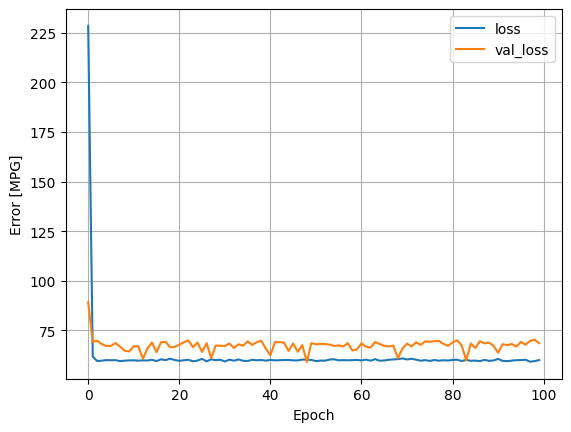

In [11]:
plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

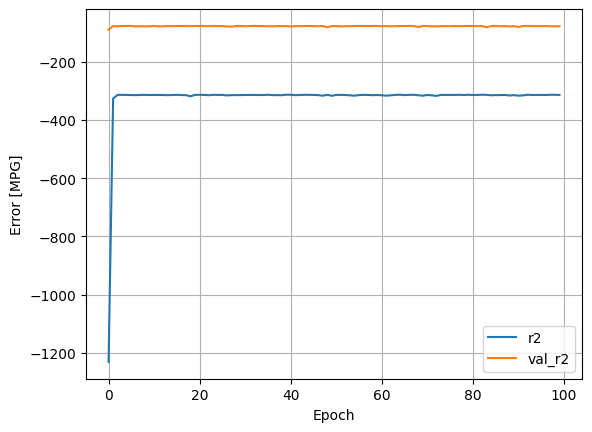

In [12]:
plt.plot(train_r2, label='r2')
plt.plot(val_r2, label='val_r2')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)